#**Fully Convolutional Neural Networks for Image Segmentation**

This project illustrates how to build a Fully Convolutional Neural Network for semantic image segmentation.

We will train the model on a [custom dataset](https://drive.google.com/file/d/0B0d9ZiqAgFkiOHR1NTJhWVJMNEU/view?usp=sharing) prepared by [divamgupta](https://github.com/divamgupta/image-segmentation-keras). This contains video frames from a moving vehicle and is a subsample of the [CamVid](http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/) dataset. 

We will be using a pretrained VGG-16 network for the feature extraction path, then followed by an FCN-8 network for upsampling and generating the predictions. The output will be a label map (i.e. segmentation mask) with predictions for 12 classes. Let's begin!

### Importing Libraries

In [1]:
import os
import zipfile
import cv2
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds
import seaborn as sns
from google.colab.patches import cv2_imshow

### Loading The Dataset

In [2]:
%%capture
if not os.path.exists('/content/fcnn-dataset.zip'):
  !wget https://storage.googleapis.com/laurencemoroney-blog.appspot.com/fcnn-dataset.zip
  !unzip /content/fcnn-dataset.zip

### Reading the images and annotations and processing them

In [3]:
def map_filename_to_image_and_mask(t_filename, a_filename, height=224, width=224):

  # Convert image and mask files to tensors 
  # loading the image and its annotation 
  img_raw = tf.io.read_file(t_filename)
  anno_raw = tf.io.read_file(a_filename)
  # decoding them as jpg images
  image = tf.image.decode_jpeg(img_raw)
  annotation = tf.image.decode_jpeg(anno_raw)
 
  # Resize image and segmentation mask to fit with the input of vgg16
  image = tf.image.resize(image, (height, width,))
  annotation = tf.image.resize(annotation, (height, width,))
  image = tf.reshape(image, (height, width, 3,))
  annotation = tf.cast(annotation, dtype=tf.int32)
  annotation = tf.reshape(annotation, (height, width, 1,))
  # separating the annotaion images to 12 images (the number of classes)
  stack_list = []

  # Reshape segmentation masks
  for c in range(len(class_names)):
    mask = tf.equal(annotation[:,:,0], tf.constant(c))
    stack_list.append(tf.cast(mask, dtype=tf.int32))

  # converting the annotation to shape of (height, width, 12)
  annotation = tf.stack(stack_list, axis=2)

  # Normalize pixels in the input image
  image = image/127.5
  image -= 1

  return image, annotation

In [4]:
# defining function to return images and annotations full pathes
def get_dataset_slice_paths(image_dir, label_map_dir):
  
  image_file_list = os.listdir(image_dir)
  label_map_file_list = os.listdir(label_map_dir)
  image_paths = [os.path.join(image_dir, fname) for fname in image_file_list]
  label_map_paths = [os.path.join(label_map_dir, fname) for fname in label_map_file_list]

  return image_paths, label_map_paths

In [5]:
BATCH_SIZE = 64
# function to read training dataset in batches
def get_training_dataset(image_paths, label_map_paths):
  
  training_dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_map_paths))
  training_dataset = training_dataset.map(map_filename_to_image_and_mask)
  training_dataset = training_dataset.shuffle(100, reshuffle_each_iteration=True)
  training_dataset = training_dataset.batch(BATCH_SIZE)
  training_dataset = training_dataset.repeat()
  training_dataset = training_dataset.prefetch(-1)

  return training_dataset

In [6]:
# function to read validation dataset in batches
def get_validation_dataset(image_paths, label_map_paths):
  
  validation_dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_map_paths))
  validation_dataset = validation_dataset.map(map_filename_to_image_and_mask)
  validation_dataset = validation_dataset.batch(BATCH_SIZE)
  validation_dataset = validation_dataset.repeat()  

  return validation_dataset

### Defining Class names and generating color to each class

In [9]:
# pixel labels in the video frames
class_names = ['sky', 'building','column/pole', 'road', 'side walk', 'vegetation', 'traffic light', 'fence', 'vehicle', 'pedestrian', 'byciclist', 'void']
# generate a list that contains one color for each class
colors = sns.color_palette(None, len(class_names))

In [10]:
# defining images and annotation pathes
training_image_paths = '/content/dataset1/images_prepped_train'
training_label_map_paths = '/content/dataset1/annotations_prepped_train/'
validation_image_paths = '/content/dataset1/images_prepped_test/'
validation_label_map_paths = '/content/dataset1/annotations_prepped_test/'

# get the paths to the images
training_image_paths, training_label_map_paths = get_dataset_slice_paths(training_image_paths,training_label_map_paths)
validation_image_paths, validation_label_map_paths = get_dataset_slice_paths(validation_image_paths,validation_label_map_paths)

# generate the train and val sets
training_dataset = get_training_dataset(training_image_paths, training_label_map_paths)
validation_dataset = get_validation_dataset(validation_image_paths, validation_label_map_paths)

In [11]:
# converting annotation to colored one
def give_color_to_annotation(annotation):

  seg_img = np.zeros( (annotation.shape[0],annotation.shape[1], 3) ).astype('float')
  
  for c in range(12):
    segc = (annotation == c)
    seg_img[:,:,0] += segc*( colors[c][0] * 255.0)
    seg_img[:,:,1] += segc*( colors[c][1] * 255.0)
    seg_img[:,:,2] += segc*( colors[c][2] * 255.0)
  
  return seg_img

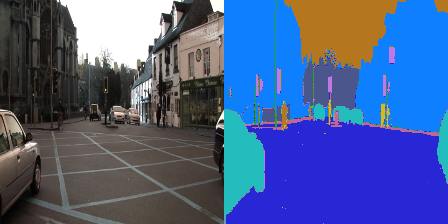

In [12]:
# showing the image and ground truth annotation side by side
def show_image_annotation(dataset):
  
  ds = dataset.unbatch()
  ds = ds.shuffle(buffer_size=100)
  
  for idx, (image, annotation) in enumerate(ds.take(1)):
    
    image = image + 1
    image = image * 127.5
    image = np.uint8(image)
    new_ann = np.argmax(annotation, axis=2)
    seg_img = give_color_to_annotation(new_ann)
    img_annot = np.hstack([image,seg_img])
    return img_annot

cv2_imshow(show_image_annotation(training_dataset))

## Defining the Model

We will now build the model and prepare it for training. this will use a VGG-16 network for the encoder and FCN-8 for the decoder. This is the diagram as shown in class:

<img src='https://drive.google.com/uc?export=view&id=1lrqB4YegV8jXWNfyYAaeuFlwXIc54aRP' alt='fcn-8'>

In [13]:
def block(x, n_convs, filters, kernel_size, activation, pool_size, pool_stride, block_name):
  
  for i in range(n_convs):
      x = tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding='same', name="{}_conv{}".format(block_name, i + 1))(x)
    
  x = tf.keras.layers.MaxPooling2D(pool_size=pool_size, strides=pool_stride, name="{}_pool{}".format(block_name, i+1 ))(x)

  return x

In [14]:
%%capture
# download the weights
!wget https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5

# assign to a variable
vgg_weights_path = "vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"

### Define VGG-16 (Encoder)


* WE will create 5 blocks with increasing number of filters at each stage. 
* The number of convolutions, filters, kernel size, activation, pool size and pool stride will remain constant.
* WE will load the pretrained weights after creating the VGG 16 network.
* Additional convolution layers will be appended to extract more features.
* The output will contain the output of the last layer and the previous four convolution blocks.

In [15]:
def VGG_16(image_input):
  
  # create 5 blocks with increasing filters at each stage. 
  x = block(image_input,n_convs=2, filters=64, kernel_size=(3,3), activation='relu',pool_size=(2,2), pool_stride=(2,2), block_name='block1')
  p1= x

  x = block(x,n_convs=2, filters=128, kernel_size=(3,3), activation='relu',pool_size=(2,2), pool_stride=(2,2), block_name='block2')
  p2 = x

  x = block(x,n_convs=3, filters=256, kernel_size=(3,3), activation='relu',pool_size=(2,2), pool_stride=(2,2), block_name='block3')
  p3 = x

  x = block(x,n_convs=3, filters=512, kernel_size=(3,3), activation='relu',pool_size=(2,2), pool_stride=(2,2), block_name='block4')
  p4 = x

  x = block(x,n_convs=3, filters=512, kernel_size=(3,3), activation='relu',pool_size=(2,2), pool_stride=(2,2), block_name='block5')
  p5 = x

  # create the vgg model
  vgg  = tf.keras.Model(image_input , p5)

  # load the pretrained weights you downloaded earlier
  vgg.load_weights(vgg_weights_path) 

  # number of filters for the output convolutional layers
  n = 4096

  # our input images are 224x224 pixels so they will be downsampled to 7x7 after the pooling layers above.
  # we can extract more features by chaining two more convolution layers.
  c6 = tf.keras.layers.Conv2D( n , ( 7 , 7 ) , activation='relu' , padding='same', name="conv6")(p5)
  c7 = tf.keras.layers.Conv2D( n , ( 1 , 1 ) , activation='relu' , padding='same', name="conv7")(c6)

  # return the outputs at each stage. 
  return (p1, p2, p3, p4, c7)

### Building FCN 8 Decoder

Next, we will build the decoder using deconvolution layers. It will involve two summations before upsampling to the original image size and generating the predicted mask.

In [16]:
def fcn8_decoder(convs, n_classes):

  # unpack the output of the encoder
  f1, f2, f3, f4, f5 = convs
  
  # upsample the output of the encoder then crop extra pixels that were introduced
  o = tf.keras.layers.Conv2DTranspose(n_classes , kernel_size=(4,4) ,  strides=(2,2) , use_bias=False )(f5)
  o = tf.keras.layers.Cropping2D(cropping=(1,1))(o)

  # load the pool 4 prediction and do a 1x1 convolution to reshape it to the same shape of `o` above
  o2 = f4
  o2 = ( tf.keras.layers.Conv2D(n_classes , ( 1 , 1 ) , activation='relu' , padding='same'))(o2)

  # add the results of the upsampling and pool 4 prediction
  o = tf.keras.layers.Add()([o, o2])

  # upsample the resulting tensor of the operation you just did
  o = (tf.keras.layers.Conv2DTranspose( n_classes , kernel_size=(4,4) ,  strides=(2,2) , use_bias=False ))(o)
  o = tf.keras.layers.Cropping2D(cropping=(1, 1))(o)

  # load the pool 3 prediction and do a 1x1 convolution to reshape it to the same shape of `o` above
  o2 = f3
  o2 = ( tf.keras.layers.Conv2D(n_classes , ( 1 , 1 ) , activation='relu' , padding='same'))(o2)

  # add the results of the upsampling and pool 3 prediction
  o = tf.keras.layers.Add()([o, o2])
  
  # upsample up to the size of the original image
  o = tf.keras.layers.Conv2DTranspose(n_classes , kernel_size=(8,8) ,  strides=(8,8) , use_bias=False )(o)

  # append a softmax to get the class probabilities
  o = (tf.keras.layers.Activation('softmax'))(o)

  return o

### Define Final Model

We can now build the final model by connecting the encoder and decoder blocks.

In [17]:
def segmentation_model():
  
  inputs = tf.keras.layers.Input(shape=(224,224,3,))
  convs = VGG_16(image_input=inputs)
  outputs = fcn8_decoder(convs, 12)
  model = tf.keras.Model(inputs=inputs, outputs=outputs)
  
  return model

In [18]:
# instantiate the model and see how it looks
model = segmentation_model()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 224, 224, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 224, 224, 64  36928       ['block1_conv1[0][0]']           
                                )                                                           

In [19]:
# compiling the model
sgd = tf.keras.optimizers.SGD(learning_rate=1e-2, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [20]:
# number of training images
train_count = 367
# number of validation images
validation_count = 101
EPOCHS = 170
steps_per_epoch = train_count//BATCH_SIZE
validation_steps = validation_count//BATCH_SIZE
history = model.fit(training_dataset,steps_per_epoch=steps_per_epoch, 
                    validation_data=validation_dataset, validation_steps=validation_steps, epochs=EPOCHS)

Epoch 1/170
5/5 [==============================] - 42s 2s/step - loss: 2.6395 - accuracy: 0.0867 - val_loss: 2.4867 - val_accuracy: 0.0874
Epoch 2/170
5/5 [==============================] - 24s 2s/step - loss: 2.4845 - accuracy: 0.0926 - val_loss: 2.4839 - val_accuracy: 0.0958
Epoch 3/170
5/5 [==============================] - 10s 2s/step - loss: 2.4818 - accuracy: 0.0989 - val_loss: 2.4826 - val_accuracy: 0.0951
Epoch 4/170
5/5 [==============================] - 10s 2s/step - loss: 2.4794 - accuracy: 0.1012 - val_loss: 2.4806 - val_accuracy: 0.0986
Epoch 5/170
5/5 [==============================] - 9s 2s/step - loss: 2.4760 - accuracy: 0.1067 - val_loss: 2.4774 - val_accuracy: 0.1056
Epoch 6/170
5/5 [==============================] - 9s 2s/step - loss: 2.4700 - accuracy: 0.1149 - val_loss: 2.4704 - val_accuracy: 0.1153
Epoch 7/170
5/5 [==============================] - 10s 2s/step - loss: 2.4578 - accuracy: 0.1265 - val_loss: 2.4580 - val_accuracy: 0.1267
Epoch 8/170
5/5 [============

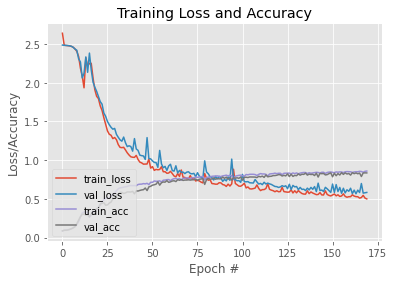

In [28]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, EPOCHS), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, EPOCHS), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, EPOCHS), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, EPOCHS), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

# saving the figure of accuracy and loss
plot_path = "plot.png"
plt.savefig(plot_path)

### Predictions

The output segmentation masks by using the model has the shape `(height, width, 12)` where `12` is the number of classes. Each pixel value in those 12 slices indicates the probability of that pixel belonging to that particular class. If you want to create the predicted label map, then you can get the `argmax()` of that axis.

In [21]:
# get the model prediction
results = model.predict(validation_dataset, steps=validation_steps)

# for each pixel, get the slice number which has the highest probability
results = np.argmax(results, axis=3)

In [22]:
# extracting the validation images and annotations
def get_images_and_segments_test_arrays():

  y_true_segments = []
  y_true_images = []
  test_count = 64

  ds = validation_dataset.unbatch()
  ds = ds.batch(101)

  for image, annotation in ds.take(1):
    y_true_images = image
    y_true_segments = annotation


  y_true_segments = y_true_segments[:test_count, : ,: , :]
  y_true_segments = np.argmax(y_true_segments, axis=3)  

  return y_true_images, y_true_segments

# load the ground truth images and segmentation masks
y_true_images, y_true_segments = get_images_and_segments_test_arrays()

### Computing Metrics

The function below generates the IOU and dice score of the prediction and ground truth masks. it is given that:

$$IOU = \frac{area\_of\_overlap}{area\_of\_union}$$
<br>
$$Dice Score = 2 * \frac{area\_of\_overlap}{combined\_area}$$

A small smoothening factor is introduced in the denominators to prevent possible division by zero.

In [23]:
def compute_metrics(y_true, y_pred):
  
  class_wise_iou = []
  class_wise_dice_score = []

  smoothening_factor = 0.00001

  for i in range(12):
    intersection = np.sum((y_pred == i) * (y_true == i))
    y_true_area = np.sum((y_true == i))
    y_pred_area = np.sum((y_pred == i))
    combined_area = y_true_area + y_pred_area
    
    iou = (intersection + smoothening_factor) / (combined_area - intersection + smoothening_factor)
    class_wise_iou.append(iou)
    
    dice_score =  2 * ((intersection + smoothening_factor) / (combined_area + smoothening_factor))
    class_wise_dice_score.append(dice_score)

  return class_wise_iou, class_wise_dice_score

In [24]:
# We can now see the predicted segmentation masks side by side with the ground truth.
def show_prediction(image,true_label,pred_label):
  
  titles = ["Image", "Predicted Mask", "True Mask"]  
  image = image + 1
  image = image * 127.5
  image = np.uint8(image)

  true_img = give_color_to_annotation(true_label)
  pred_img = give_color_to_annotation(pred_label)
  img_annot = np.hstack([image,true_img,pred_img])
  return img_annot

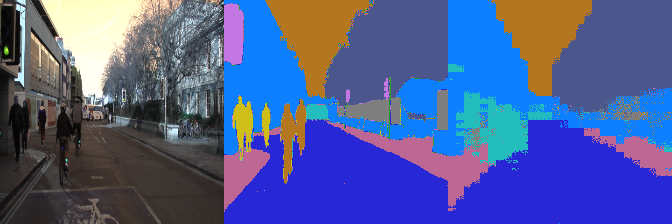

In [25]:
random_index = np.random.choice(range(64))
test_image = y_true_images[random_index]
true_test_label = y_true_segments[random_index]
pred_test_label = results[random_index]

cv2_imshow(show_prediction(test_image,true_test_label,pred_test_label))

In [26]:
iou_list, dice_score_list = compute_metrics(true_test_label, pred_test_label) 

In [27]:
metrics_by_id = [(idx, iou, dice_score) for idx, (iou, dice_score) in enumerate(zip(iou_list, dice_score_list)) if iou > 0.0]
metrics_by_id.sort(key=lambda tup: tup[1], reverse=True)  # sorts in place

display_string_list = ["{}: IOU: {}  Dice Score: {}".format(class_names[idx], iou, dice_score) for idx, iou, dice_score in metrics_by_id]
display_string = "\n".join(display_string_list) 
print(display_string)

road: IOU: 0.8997093023863194  Dice Score: 0.9472073454006608
sky: IOU: 0.8895922549067357  Dice Score: 0.941570599131372
vegetation: IOU: 0.8435677843990819  Dice Score: 0.915147023021919
side walk: IOU: 0.660623641139416  Dice Score: 0.7956331895260071
building: IOU: 0.5637315821376429  Dice Score: 0.7210081178855604
void: IOU: 0.20356612420931314  Dice Score: 0.33827160904130466
fence: IOU: 0.11297071542087067  Dice Score: 0.2030075263032267
vehicle: IOU: 0.06290849928401825  Dice Score: 0.11837048906387268
byciclist: IOU: 0.003571437468112165  Dice Score: 0.007117455452691677
pedestrian: IOU: 0.0009442964972209963  Dice Score: 0.0018868113029546106
column/pole: IOU: 4.149377421187659e-08  Dice Score: 8.298754842375318e-08
traffic light: IOU: 7.457121495472621e-09  Dice Score: 1.4914242990945243e-08


### We Can conclude that the results isn't very well so we will try U-Net in the next notebook.